In [156]:
import os, sys
import ogr
from math import ceil,sqrt
import pandas as pd
import gdal
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon
import fiona
from shapely.geometry import Point

In [157]:
grid_fire_dir='/home/jupyter/data/perimeters/'
grid_fire_dir_nn='/home/jupyter/data/perimeters_nn/'

In [158]:
input_data_dir='/home/jupyter/NeuralNetwork/Inputs/'
square_dir='/home/jupyter/NeuralNetwork/Square_grids/'
pixel_dir='/home/jupyter/NeuralNetwork/Pixels/'
clim_data_dir='/home/jupyter/NeuralNetwork/Spot_climate/'

In [159]:
import glob

allFiles = glob.glob(input_data_dir + "*.csv")
allFiles_df=pd.DataFrame(v.replace('/home/jupyter/NeuralNetwork/Inputs/','').replace('.csv','') for v in allFiles)
allFiles_df.columns=['fire_id']


In [160]:
def import_fire_and_return_parameters(fire):

    grid_batch=gpd.read_file(grid_fire_dir+fire+'.shp')
    fire_master=pd.read_csv(input_data_dir+fire+'.csv')
    grid_batch=grid_batch.merge(fire_master, how='inner',on='us_gid_to_')
    grid_batch.to_file(driver='ESRI Shapefile',filename=grid_fire_dir_nn+fire+'.shp')

        
    someNewMinX=grid_batch.bounds.minx.min()
    someNewMinY=grid_batch.bounds.miny.min()
    someNewMaxX=grid_batch.bounds.maxx.max()
    someNewMaxY=grid_batch.bounds.maxy.max()
    num_hexes=grid_batch.shape[0]
    cells_side=sqrt(grid_batch.shape[0]*2)
    min_extent=abs(min(someNewMaxX-someNewMinX,someNewMaxY-someNewMinY))
    grid_dim=min_extent/cells_side
    return someNewMinX,someNewMaxX,someNewMinY,someNewMaxY,grid_dim

        


In [164]:


def create_pixels(fire_id):
    #make pixel size constant
    #make x_res and y_res constant
    #across all frames

    x_min_raw,x_max_raw,y_min_raw,y_max_raw,lalala=import_fire_and_return_parameters(fire_id)
    
    #source_layer_gpd=gpd.read_file()
    source_ds = ogr.Open(grid_fire_dir_nn+fire_id+'.shp')
    source_layer = source_ds.GetLayer()
    
    
    
    master_ext=min((x_max_raw-x_min_raw),(y_max_raw-y_min_raw))*0.75
    pixel_size=master_ext/128
    offset_x=(master_ext-(x_max_raw-x_min_raw))/2
    offset_y=(master_ext-(y_max_raw-y_min_raw))/2
    #print(offset_x)
    #print(offset_y)
    
    
    x_max=x_max_raw+offset_x
    x_min=x_min_raw-offset_x
    y_max=y_max_raw+offset_y
    y_min=y_min_raw-offset_y
    
    #print((y_max - y_min))
    # Create the destination data source
    x_res=128
    y_res=128
    #x_res = int((x_max - x_min) / pixel_size)
    #y_res = int((y_max - y_min) / pixel_size)
    #print((x_max - x_min))
    #print((y_max - y_min))
    #print(x_res)
    #print(y_res)
    target_ds = gdal.GetDriverByName('GTiff').Create('temp.tif', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(255)

    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])

    # Read as array
    array = band.ReadAsArray()

    raster = gdal.Open('temp.tif')
    geotransform = raster.GetGeoTransform()

    # Convert array to point coordinates
    count = 0
    roadList = np.where(array)
    #roadList = np.where(array == 1)
    multipoint = ogr.Geometry(ogr.wkbMultiPoint)
    for indexY in roadList[0]:
        indexX = roadList[1][count]
        geotransform = raster.GetGeoTransform()
        originX = geotransform[0]
        originY = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = geotransform[5]
        Xcoord = originX+pixelWidth*indexX
        Ycoord = originY+pixelHeight*indexY
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(Xcoord, Ycoord)
        multipoint.AddGeometry(point)
        #point.AddGeometry(point)
        count += 1

    # Write point coordinates to Shapefile
    outputdir=square_dir+fire_id+'_rawpix.shp'
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outputdir):
        shpDriver.DeleteDataSource(outputdir)
    outDataSource = shpDriver.CreateDataSource(outputdir)
    outLayer = outDataSource.CreateLayer(outputdir, geom_type=ogr.wkbMultiPoint)
    featureDefn = outLayer.GetLayerDefn()
    outFeature = ogr.Feature(featureDefn)
    outFeature.SetGeometry(multipoint)
    #outFeature.SetGeometry(point)
    outLayer.CreateFeature(outFeature)
    outFeature = None

    # Remove temporary files
    os.remove('temp.tif')

def getXY(pt):
    return (pt.x, pt.y)



def populate_pixels(fire_id):
    pixels=gpd.read_file(square_dir+fire_id+'_rawpix.shp')
    gs =gpd.GeoDataFrame(gpd.GeoSeries(pnt for pnt in pixels['geometry'][0]))
    gs = gs.rename(columns={0:'geometry'}).set_geometry('geometry')
    gs.crs = fiona.crs.from_epsg(4326)

    source_layer_gpd=gpd.read_file(grid_fire_dir_nn+fire_id+'.shp')
    source_layer_gpd=source_layer_gpd[['us_gid_to_','geometry']]
    
    fire_master=pd.read_csv(input_data_dir+fire_id+'.csv')
    weather_master=pd.read_csv(clim_data_dir+fire_id+'.csv')
    
    #print(fire_master.columns)
    source_layer_gpd=source_layer_gpd.merge(fire_master, how='left',on='us_gid_to_')
    #print(source_layer_gpd.sample(100))
    source_layer_gpd=source_layer_gpd.merge(weather_master, how='left',on='us_gid_to_')
    
    gs = gpd.sjoin(gs, source_layer_gpd, how="left", op='within')
    gs['x_co']=gs["geometry"].x
    gs['y_co']=gs["geometry"].y
    gs['x_rank'] = gs['x_co'].rank(ascending=True, method='dense')
    gs['y_rank'] = gs['y_co'].rank(ascending=True, method='dense')
    gs['pixel_order']=gs['x_rank']*gs['y_rank']
    #add pixel order (x_rank*y_rank)
   
    gs.to_file(driver='ESRI Shapefile',filename=pixel_dir+fire_id+'_pixels.shp')


In [162]:
for i,row in allFiles_df.iterrows():
    create_pixels(row['fire_id'])

In [165]:
import warnings
warnings.filterwarnings('ignore')
import multiprocessing

def func(d):
    for i,row in d.iterrows():
        
        populate_pixels(row['fire_id'])
        


def parallelize_dataframe(df, func):
    num_cores = multiprocessing.cpu_count()-1 
    print(num_cores)
    num_partitions = num_cores 
    df_split = np.array_split(df.sample(frac=1).reset_index(drop=True), num_partitions)
    pool = multiprocessing.Pool(num_cores)
    pool.map(func, df_split)
    pool.close()

    return df

parallelize_dataframe(allFiles_df,func)

 

15


,fire_id
0,CALAC-362189
1,CAMDF-000777
2,CASTF-001940
3,CALFD-030179
4,CASKU-005949
5,CASRF-000874
6,CASQF-002435
7,CASNF-001419
8,CASRF-000928
9,CAMDF-000716


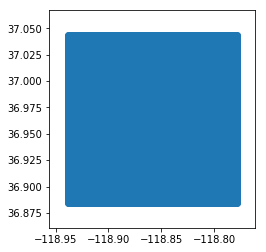

In [166]:
pixels=gpd.read_file(pixel_dir+'CASNF-001419_pixels.shp')
pixels.plot()

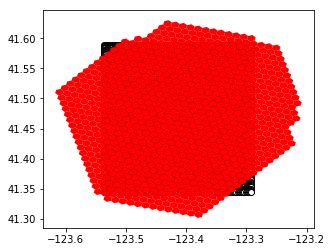

In [170]:
square_grid=gpd.read_file(pixel_dir+'CASRF-000914_pixels.shp')
grid_batch=gpd.read_file(grid_fire_dir_nn+'CASRF-000914.shp')

base = square_grid.plot(color='white', edgecolor='black')
grid_batch.plot(ax=base, color='red');
#print(square_grid)
#test=square_grid.dropna(subset=['ring'])
#test.plot()



In [168]:
#populate_pixels('CASRF-000914')

In [169]:
square_grid.sample(20)

,index_righ,us_gid_to_,Unnamed_ 0,on_fire,fire_start,ring,landcover_,elevation_,pop_sqkm_x,landcove_1,...,Unnamed__1,temp,prcp,wdsp,x_co,y_co,x_rank,y_rank,pixel_orde,geometry
9577,18.0,411126441.0,18.0,0.0,999999.0,3.0,162.0,551.0,0.174620,162.0,...,94.0,62.444334,0.009330,71.837010,-123.333936,41.446510,106.0,54.0,5724.0,POINT (-123.3339363420545 41.44650953462567)
6643,707.0,411126422.0,707.0,0.0,999999.0,7.0,162.0,1561.0,0.117231,162.0,...,1536.0,62.506172,0.009308,70.459357,-123.314699,41.490756,116.0,77.0,8932.0,POINT (-123.3146988663431 41.49075572876175)
4227,133.0,411121055.0,133.0,0.0,999999.0,16.0,55.0,249.0,0.117231,55.0,...,352.0,62.097205,0.009461,61.895491,-123.530159,41.525383,4.0,95.0,380.0,POINT (-123.5301585943101 41.52538318504215)
9718,814.0,411126452.0,814.0,0.0,999999.0,5.0,162.0,1027.0,0.232008,162.0,...,1866.0,62.489637,0.009313,72.872814,-123.308928,41.444586,119.0,53.0,6307.0,POINT (-123.3089276236297 41.44458578705454)
12458,328.0,411120025.0,328.0,0.0,607.0,8.0,55.0,559.0,0.117231,55.0,...,958.0,62.247896,0.009398,70.211152,-123.455132,41.402263,43.0,31.0,1333.0,POINT (-123.4551324390359 41.40226334048959)
11487,337.0,411120620.0,337.0,0.0,999999.0,3.0,162.0,1038.0,0.232008,162.0,...,967.0,62.416929,0.009338,72.511284,-123.353174,41.417653,96.0,39.0,3744.0,POINT (-123.3531738177658 41.41765332105867)
1984,469.0,411121601.0,469.0,0.0,999999.0,12.0,162.0,1129.0,0.117231,162.0,...,1175.0,62.325951,0.009365,64.151939,-123.412810,41.560011,65.0,113.0,7345.0,POINT (-123.4128099924709 41.56001064132256)
7423,831.0,411126413.0,831.0,0.0,999999.0,8.0,162.0,915.0,0.117231,162.0,...,1883.0,62.534116,0.009299,71.509124,-123.291614,41.479213,128.0,71.0,9088.0,POINT (-123.2916138954895 41.47921324333494)
3785,266.0,411126332.0,266.0,1.0,648.0,9.0,162.0,1528.0,0.117231,162.0,...,584.0,62.355154,0.009360,65.871811,-123.395496,41.533078,74.0,99.0,7326.0,POINT (-123.3954962643307 41.53307817532669)
15537,544.0,411120056.0,544.0,0.0,999999.0,12.0,55.0,673.0,0.232008,55.0,...,1250.0,62.270151,0.009384,72.849851,-123.441666,41.356093,50.0,7.0,350.0,POINT (-123.441666206038 41.35609339878238)
